# Сверточные нейронные сети (ноутбук)

> Знакомимся со сверточными нейронными сетями. Учимся решать задачу классификации изображений.

In [117]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms.v2 as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

## Загрузка изображения

Загрузим изображение из интернета, например, Питер Гриффина из одноименного мультсериала "Гриффины".

In [ ]:
! wget "https://static.independent.co.uk/2021/10/29/14/newFile-8.jpg?width=1200" -O peter.jpg

--2023-10-23 12:12:57--  https://static.independent.co.uk/2021/10/29/14/newFile-8.jpg?width=1200
Resolving static.independent.co.uk (static.independent.co.uk)... 146.75.117.91, 2a04:4e42:8d::347
Connecting to static.independent.co.uk (static.independent.co.uk)|146.75.117.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112326 (110K) [image/jpeg]
Saving to: ‘peter.jpg’

peter.jpg           100%[===================>] 109.69K  --.-KB/s    in 0.07s   

2023-10-23 12:12:58 (1.48 MB/s) - ‘peter.jpg’ saved [112326/112326]



## Чтение изображения

In [118]:
img = Image.open('photo_for_debug.jpg')

In [119]:
img.format

'JPEG'

In [120]:
img.size

(960, 1280)

In [121]:
img.mode

'RGB'

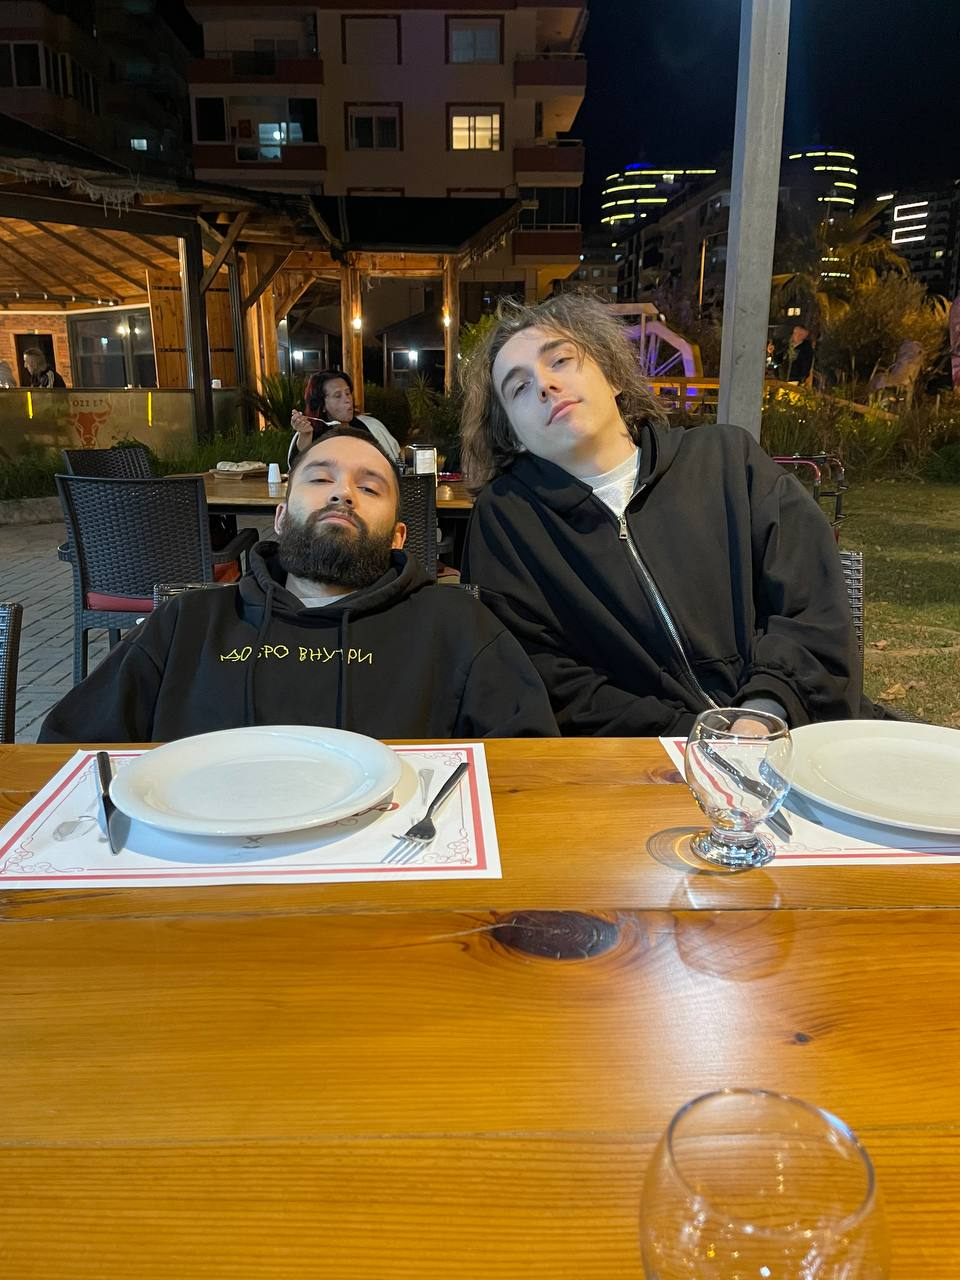

In [122]:
img

## Матричное представление

In [125]:
img_matrix_notvalid_shape = T.ToTensor()(img)
img_matrix = torch.permute(img_matrix_notvalid_shape, (1, 2, 0))

In [126]:
img_matrix.shape

torch.Size([1280, 960, 3])

In [127]:
img_matrix.shape

torch.Size([1280, 960, 3])

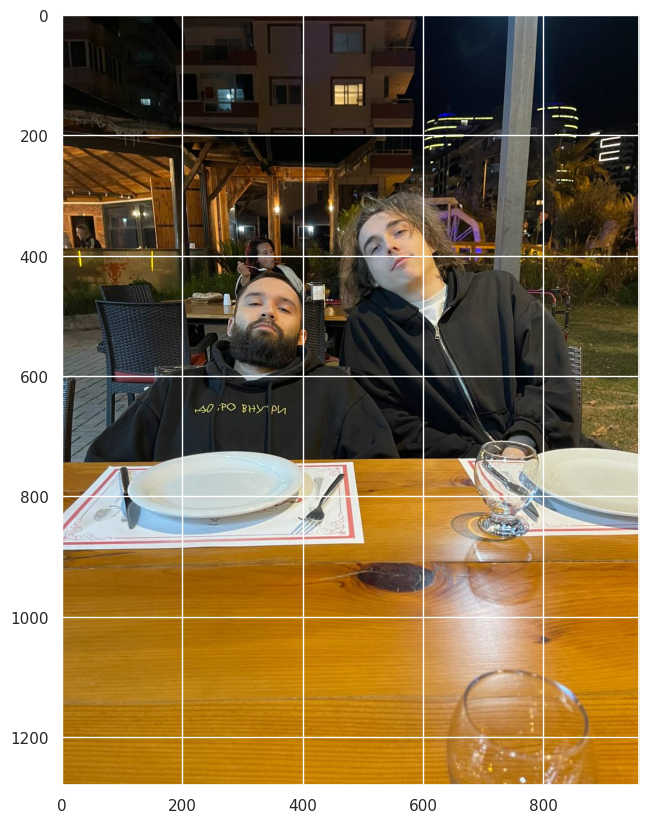

In [128]:
plt.figure(figsize=(20, 10))

plt.imshow(img_matrix)

plt.show()

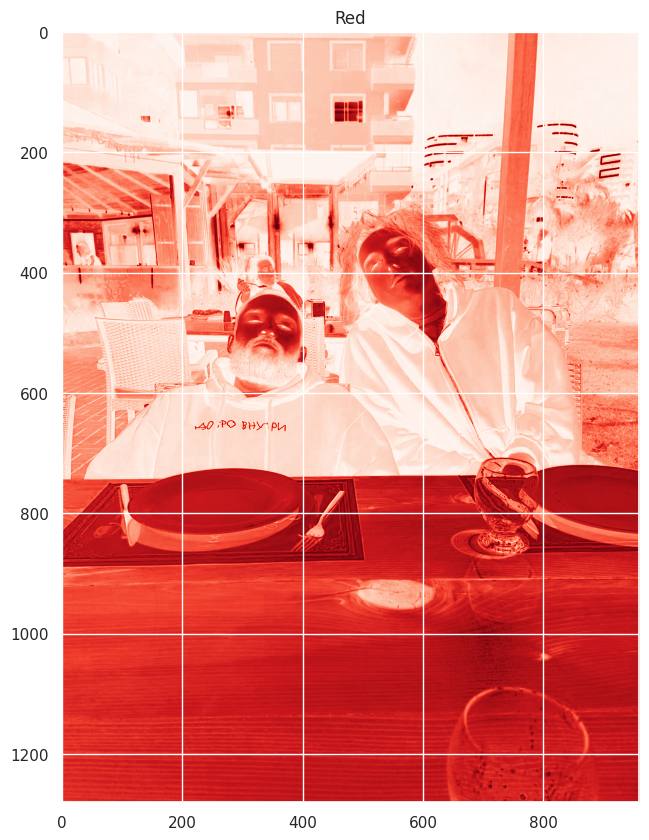

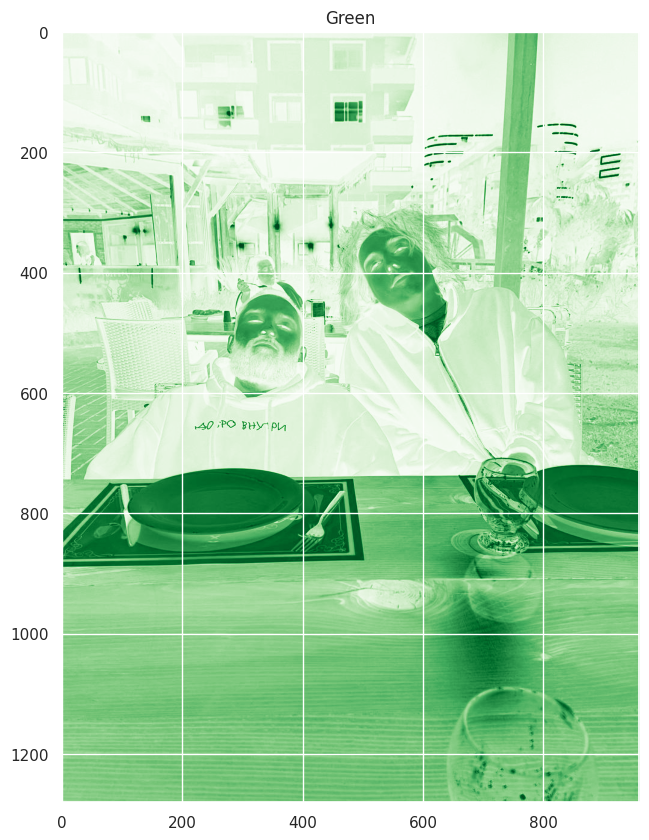

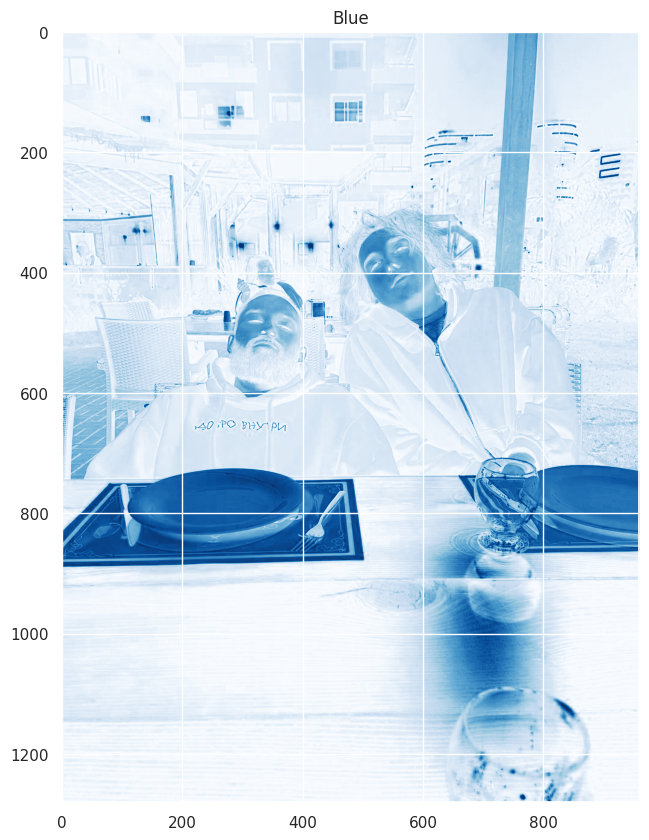

In [129]:
for i, (cmap, color) in enumerate(
    zip(
        [cm.Reds, cm.Greens, cm.Blues],
        ['Red', 'Green', 'Blue']
    )
):
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matrix[:, :, i], cmap=cmap)
    plt.title(color)
    plt.show()

In [130]:
img_matrix[:, :, 0].min(), img_matrix[:, :, 0].max()

(tensor(0.), tensor(1.))

In [132]:
img_matrix.shape

torch.Size([1280, 960, 3])

In [137]:
img_matrix

tensor([[[0.0471, 0.0275, 0.0157],
         [0.0510, 0.0314, 0.0196],
         [0.0510, 0.0314, 0.0196],
         ...,
         [0.0196, 0.0627, 0.0863],
         [0.0196, 0.0627, 0.0863],
         [0.0196, 0.0627, 0.0863]],

        [[0.0824, 0.0627, 0.0510],
         [0.0824, 0.0627, 0.0510],
         [0.0824, 0.0627, 0.0510],
         ...,
         [0.0196, 0.0627, 0.0863],
         [0.0196, 0.0627, 0.0863],
         [0.0196, 0.0627, 0.0863]],

        [[0.1098, 0.0902, 0.0784],
         [0.1098, 0.0902, 0.0784],
         [0.1098, 0.0902, 0.0784],
         ...,
         [0.0196, 0.0627, 0.0863],
         [0.0196, 0.0627, 0.0863],
         [0.0196, 0.0627, 0.0863]],

        ...,

        [[0.6353, 0.4039, 0.0000],
         [0.6353, 0.4039, 0.0000],
         [0.6314, 0.4000, 0.0000],
         ...,
         [0.8000, 0.4941, 0.0000],
         [0.8000, 0.4941, 0.0000],
         [0.8039, 0.4980, 0.0039]],

        [[0.6431, 0.4118, 0.0039],
         [0.6392, 0.4078, 0.0000],
         [0.

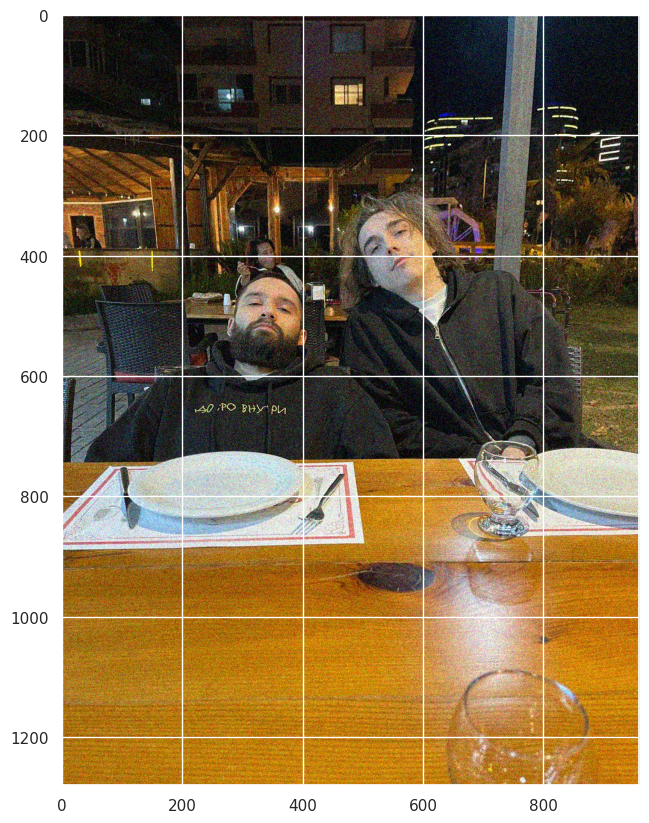

In [136]:
noise_photo = img_matrix + torch.randn_like(img_matrix) * 0.1

plt.figure(figsize=(20, 10))

plt.imshow(noise_photo)

plt.show()

## Свертка

Свертка в `PyTorch` представлена модулем `nn.Conv2d` со следующими параметрами:

- in_channels (int) – Количество каналов во входном изображении

- out_channels (int) – Количество каналов в выходном изображении

- kernel_size (int or tuple) – Размер ядра свертки

- stride (int or tuple, optional) – Страйд (шаг ядра свертки). По умолчанию: 1

- padding (int, tuple or str, optional) – Размер паддинга. По умолчанию: 0

- padding_mode (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. По умолчанию: 'zeros'

- dilation (int or tuple, optional) – Дилейшн (шаг между элементами внутри ядра). По умолчанию: 1

- bias (bool, optional) – добавлять ли обучаемый сдвиг. По умолчанию: True

In [138]:
conv1 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3
    # stride = 1
    # padding = 0
    # dilation = 1
    # groups = 1
)

In [139]:
img_matrix.shape

torch.Size([1280, 960, 3])

In [140]:
(1280 + 2 * 1 - 1 * 2 - 1) / 1 + 1

1278.0

$\begin{aligned} & H_{\text {out }}=\left\lfloor\frac{H_{\text {in }}+2 \times \text { padding }[0]-\operatorname{dilation}[0] \times(\text { kernel_size }[0]-1)-1}{\text { stride }[0]}+1\right\rfloor \\ & W_{\text {out }}=\left\lfloor\frac{W_{\text {in }}+2 \times \text { padding }[1]-\operatorname{dilation}[1] \times(\text { kernel_size }[1]-1)-1}{\operatorname{stride}[1]}+1\right\rfloor\end{aligned}$

In [141]:
add_batch_shape = img_matrix.unsqueeze(0) # shape (Batch (=1), first dim (=1280), second (=960), channels (=3))
img_tensor = torch.permute(add_batch_shape, (0, 3, 2, 1))

In [142]:
img_tensor.shape, img_matrix.shape

(torch.Size([1, 3, 960, 1280]), torch.Size([1280, 960, 3]))

In [143]:
output = conv1(img_tensor)

In [145]:
output.shape

torch.Size([1, 10, 958, 1278])

In [146]:
conv2 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    padding=1
)

In [147]:
output = conv2(img_tensor)

In [148]:
output.shape

torch.Size([1, 10, 960, 1280])

In [ ]:
output

tensor([[[[ 0.1061, -0.0969, -0.0969,  ..., -0.0989, -0.0989, -0.3941],
          [ 0.0921, -0.0233, -0.0233,  ..., -0.0161, -0.0161, -0.2254],
          [ 0.0921, -0.0233, -0.0233,  ..., -0.0163, -0.0163, -0.2261],
          ...,
          [ 0.0816,  0.0077,  0.0077,  ..., -0.0530, -0.0530, -0.1769],
          [ 0.0816,  0.0077,  0.0077,  ..., -0.0521, -0.0521, -0.1771],
          [ 0.0099, -0.0337, -0.0337,  ..., -0.0646, -0.0646, -0.0523]],

         [[-0.2441, -0.3818, -0.3818,  ..., -0.4254, -0.4254, -0.4667],
          [-0.3252, -0.4473, -0.4473,  ..., -0.4971, -0.4971, -0.5117],
          [-0.3252, -0.4473, -0.4473,  ..., -0.4967, -0.4967, -0.5118],
          ...,
          [-0.3523, -0.4424, -0.4424,  ..., -0.3827, -0.3827, -0.3898],
          [-0.3523, -0.4424, -0.4424,  ..., -0.3831, -0.3831, -0.3891],
          [-0.0718, -0.2060, -0.2060,  ..., -0.1691, -0.1691, -0.3131]],

         [[ 0.4853,  0.4545,  0.4545,  ...,  0.4818,  0.4818,  0.1244],
          [ 0.3706,  0.2351,  

In [185]:
conv2.weight

Parameter containing:
tensor([[[[-2.1576e-02,  9.4216e-02,  1.5238e-01],
          [-1.6490e-01,  5.7542e-02,  7.3107e-02],
          [-7.4350e-02,  2.6506e-02,  5.0038e-02]],

         [[ 5.1598e-02, -1.3613e-01, -4.0701e-03],
          [-2.1150e-02, -8.2114e-02,  1.3180e-01],
          [ 8.2256e-02,  3.7558e-02, -1.5821e-01]],

         [[ 3.5751e-03,  1.0176e-01, -9.6165e-02],
          [ 3.1911e-02,  4.9135e-03, -5.4470e-02],
          [ 8.5924e-02,  1.3376e-01,  1.1620e-01]],

         [[ 9.8462e-02,  1.0679e-02, -1.6271e-01],
          [-1.3782e-01,  1.0335e-01, -6.3637e-02],
          [-9.3407e-02,  6.5570e-02, -1.4507e-01]]],


        [[[-1.2387e-01,  1.4932e-02, -5.6816e-02],
          [ 1.5178e-01, -1.2403e-01, -2.6097e-02],
          [ 2.4526e-02, -1.5034e-01,  4.6344e-02]],

         [[ 3.9238e-02, -1.3986e-01, -1.0814e-01],
          [ 2.9434e-02, -9.9949e-02,  5.7460e-02],
          [-6.8289e-02, -1.4217e-01,  8.4493e-02]],

         [[ 9.6045e-03, -8.1280e-02, -7.2933e-

In [150]:
conv2.bias.shape

torch.Size([10])

## Пулинг

Пулинг представлен в модуле `torch.nn`, в основном будем использовать `MaxPool2d` и `AvgPool2d`.

Параметры:

- kernel_size – размер окошка

- stride – страйд окошка. По умолчанию равен kernel_size

- padding – сколько нулевого паддинга добавлять по краям. По умолчанию: 0.

In [153]:
img_tensor = torch.randint(0, 10, size=(10, 10), dtype=torch.float32).unsqueeze(0)

In [156]:
img_tensor

tensor([[[2., 9., 1., 6., 8., 6., 1., 9., 9., 9.],
         [7., 4., 1., 2., 3., 1., 9., 3., 5., 0.],
         [4., 8., 8., 4., 7., 3., 9., 4., 5., 9.],
         [5., 6., 2., 8., 1., 0., 6., 0., 1., 5.],
         [9., 2., 5., 2., 9., 6., 4., 1., 7., 1.],
         [6., 4., 4., 9., 7., 0., 2., 5., 3., 2.],
         [0., 6., 1., 4., 3., 6., 9., 1., 6., 6.],
         [7., 3., 3., 1., 1., 1., 0., 9., 3., 4.],
         [4., 9., 1., 8., 3., 2., 0., 8., 9., 6.],
         [8., 2., 8., 3., 5., 9., 8., 9., 2., 7.]]])

In [157]:
pooling1 = nn.MaxPool2d(kernel_size=2)

In [158]:
pooling1(img_tensor)

tensor([[[9., 6., 8., 9., 9.],
         [8., 8., 7., 9., 9.],
         [9., 9., 9., 5., 7.],
         [7., 4., 6., 9., 6.],
         [9., 8., 9., 9., 9.]]])

In [159]:
pooling2 = nn.AvgPool2d(kernel_size=2)

In [160]:
pooling2(img_tensor)

tensor([[[5.5000, 2.5000, 4.5000, 5.5000, 5.7500],
         [5.7500, 5.5000, 2.7500, 4.7500, 5.0000],
         [5.2500, 5.0000, 5.5000, 3.0000, 3.2500],
         [4.0000, 2.2500, 2.7500, 4.7500, 4.7500],
         [5.7500, 5.0000, 4.7500, 6.2500, 6.0000]]])

## Датасет MNIST

In [161]:
mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True
)
mnist_train[0][0]

In [162]:
mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=T.ToTensor()
)

In [163]:
mnist_valid = MNIST(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [164]:
len(mnist_train)

60000

In [165]:
len(mnist_valid)

10000

In [167]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [168]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

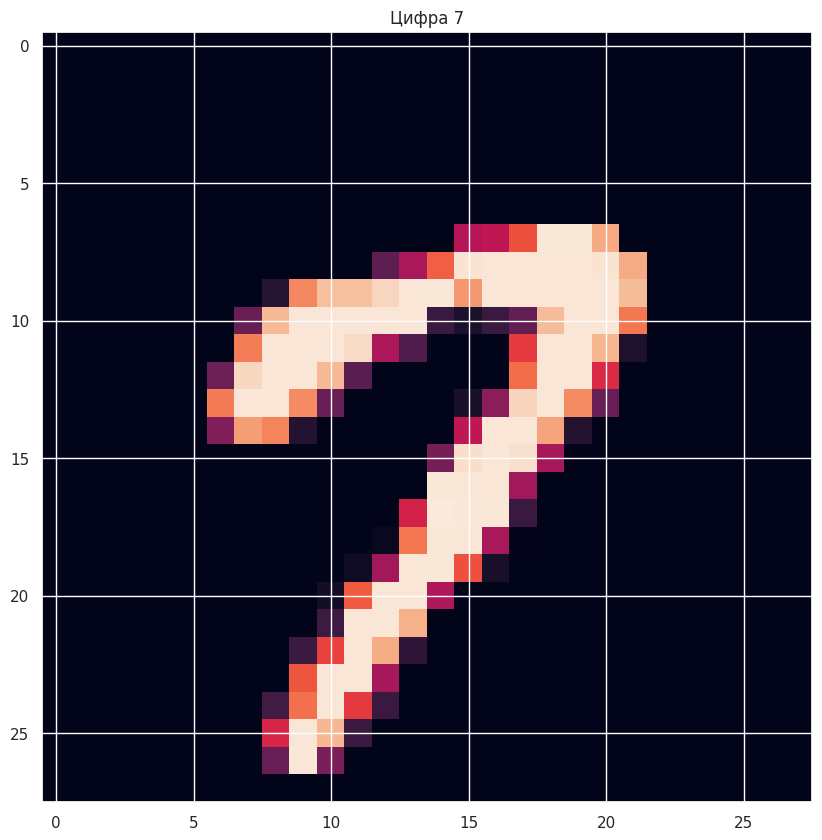

In [173]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {mnist_train[15][1]}')
plt.imshow(mnist_train[15][0][0])

plt.show()

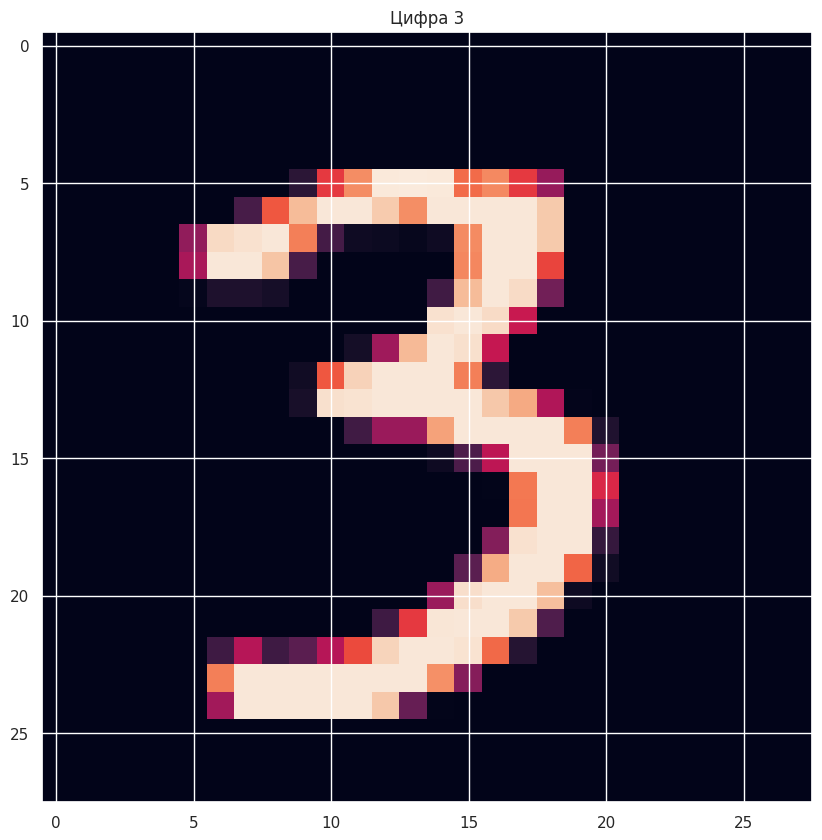

In [170]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {mnist_train[10000][1]}')
plt.imshow(mnist_train[10000][0][0])

plt.show()

## Полносвязная нейронная сеть

Обучим полносвязную нейронную сеть на датасете MNIST.

In [174]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer


def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn):
    model.train()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

        optimizer.step()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [175]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn):
    model.eval()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [176]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='darkgrid')


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()

    plt.show()

In [177]:
from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

In [178]:
first_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

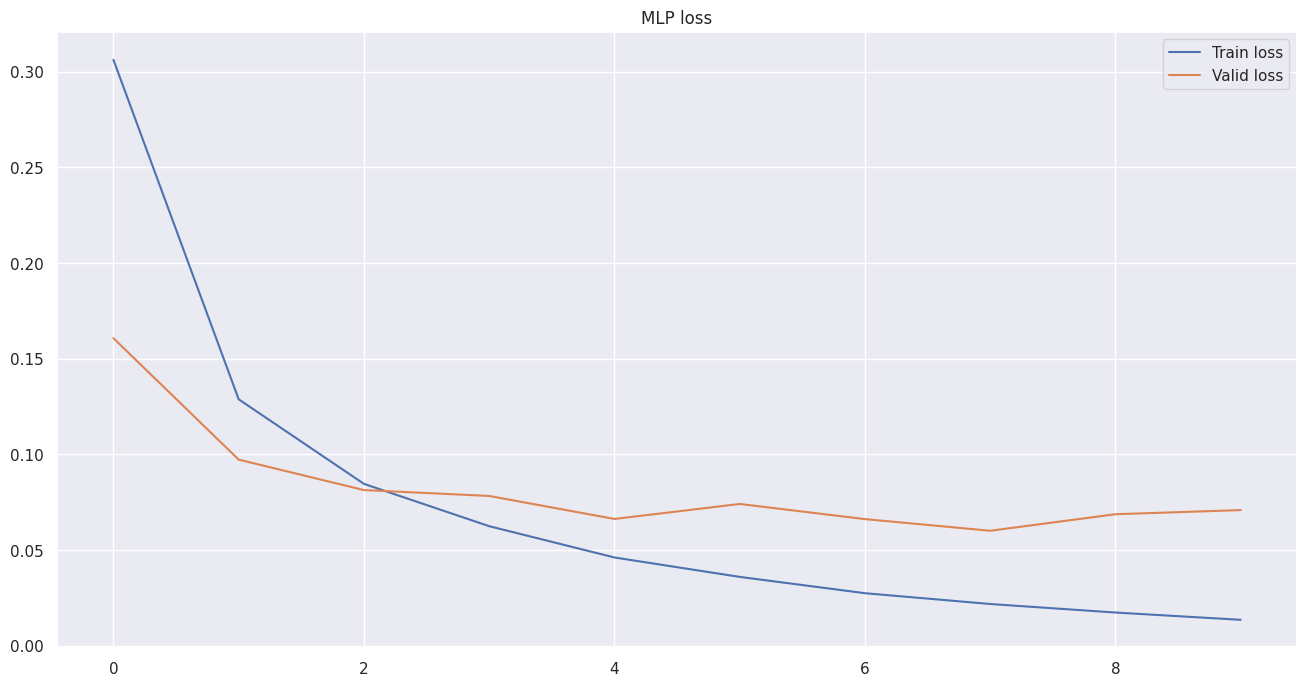

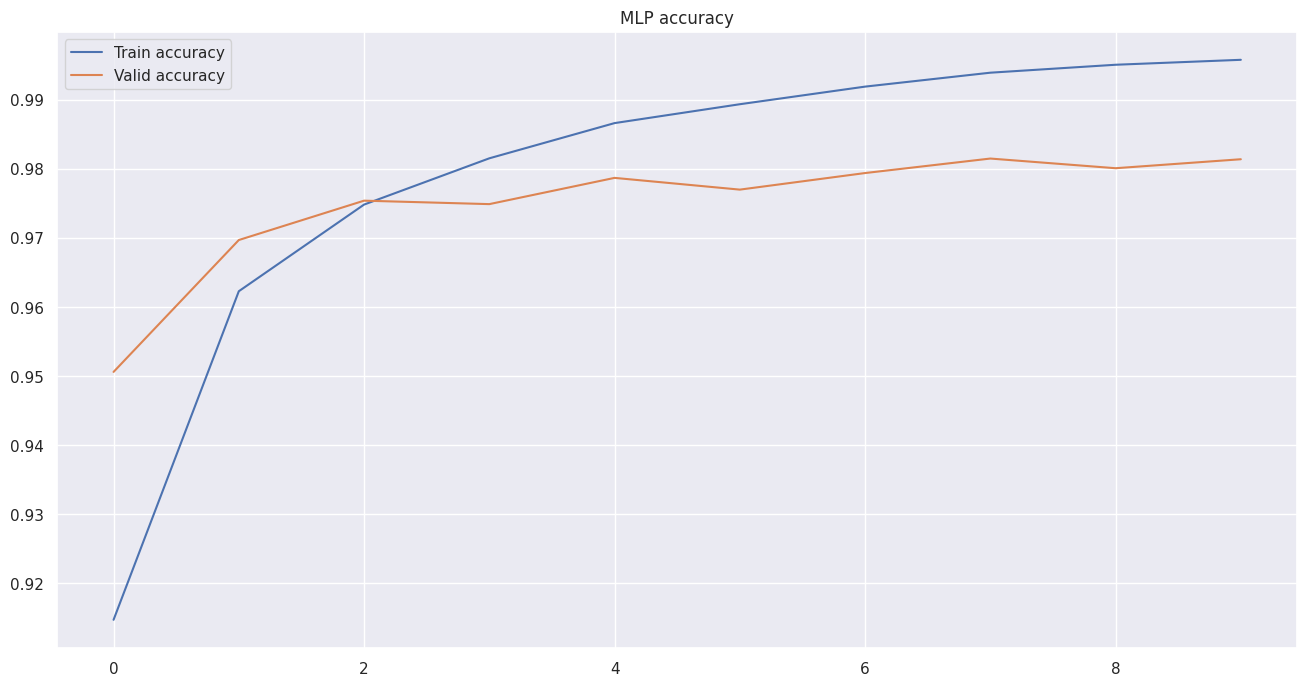

  4%|▍         | 38/938 [00:00<00:13, 64.84it/s]


KeyboardInterrupt: 

In [179]:
fit(first_model, train_loader, valid_loader, optimizer, loss_fn, 15, 'MLP')

## Сверточная сеть

In [181]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),  # 28 x 28 -> 24 x 24
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2),  # 24 x 24 -> 12 x 12

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),  # 12 x 12 -> 8 x 8
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2),  # 8 x 8 -> 4 x 4

    nn.Flatten(),  # 4 x 4 x 16 -> 4 * 4 * 16
    nn.Linear(4 * 4 * 16, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.Adam(second_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

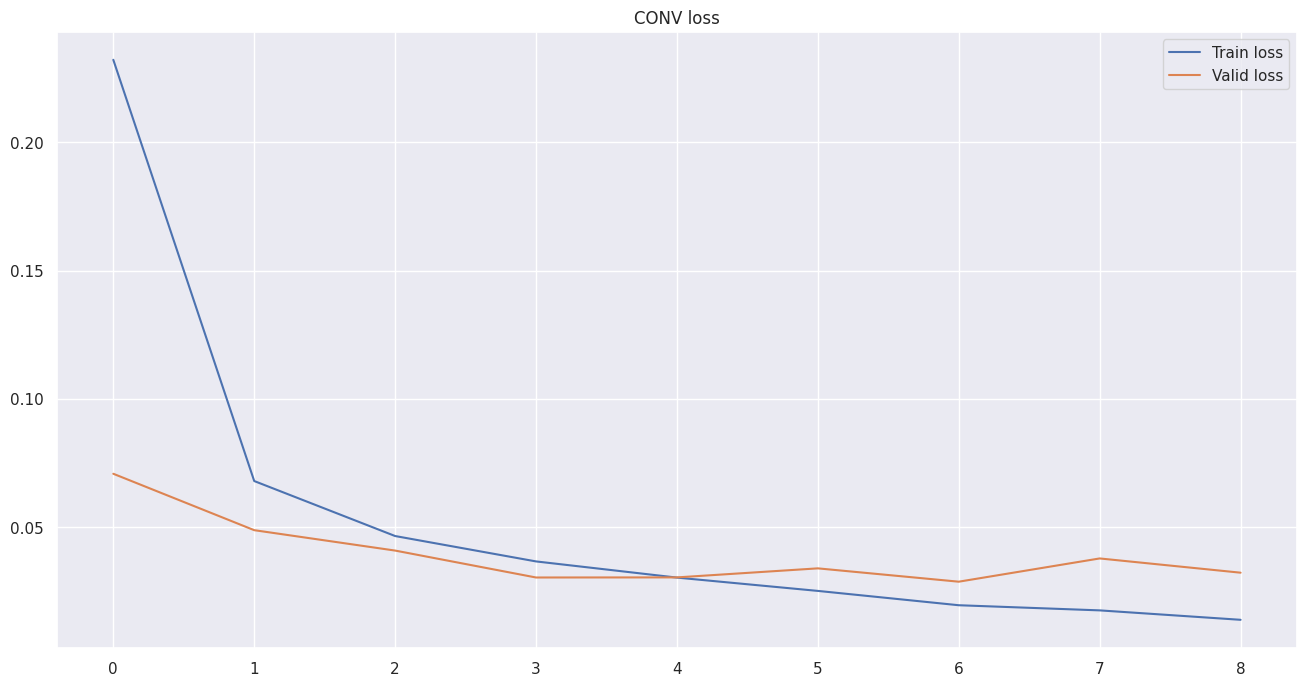

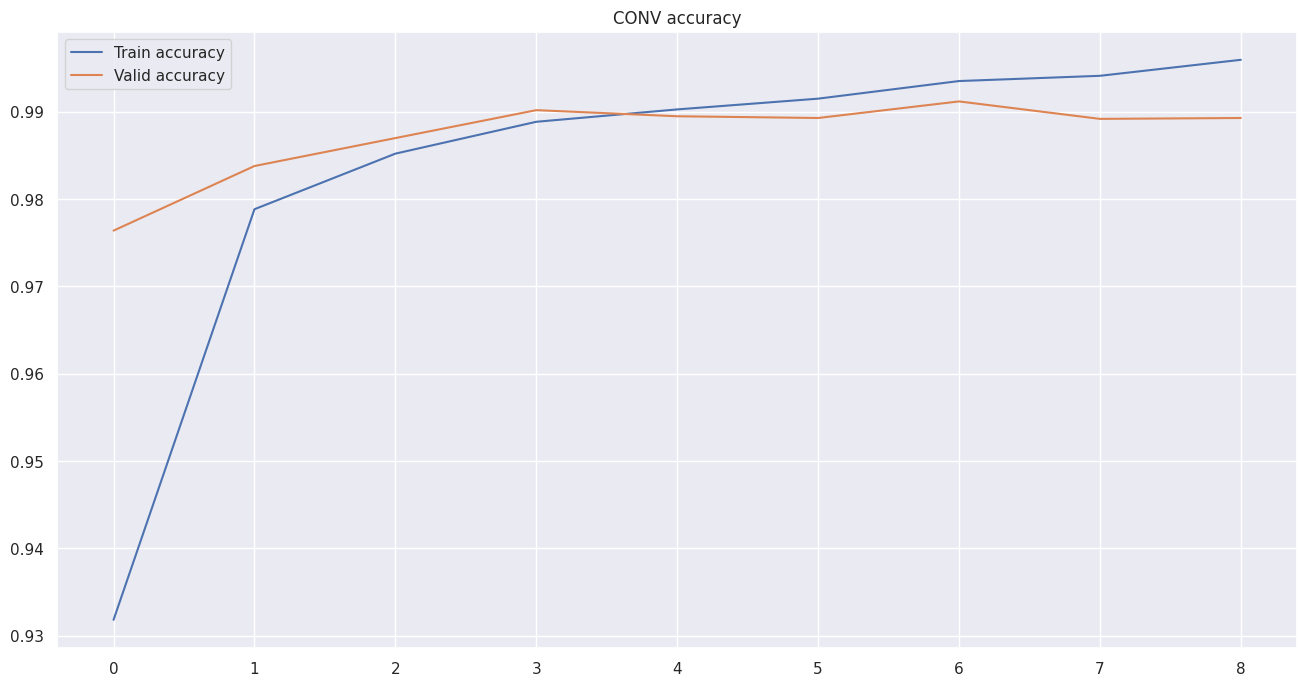

In [182]:
fit(second_model, train_loader, valid_loader, optimizer, loss_fn, 9, 'CONV')

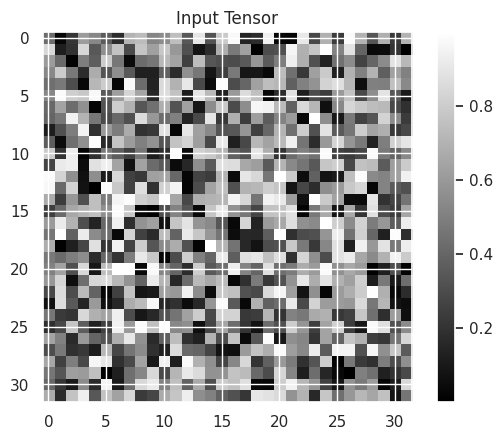

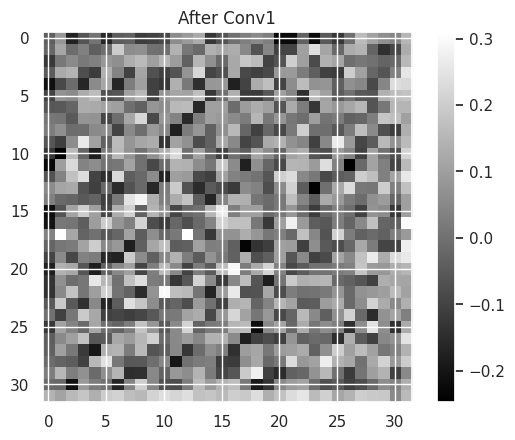

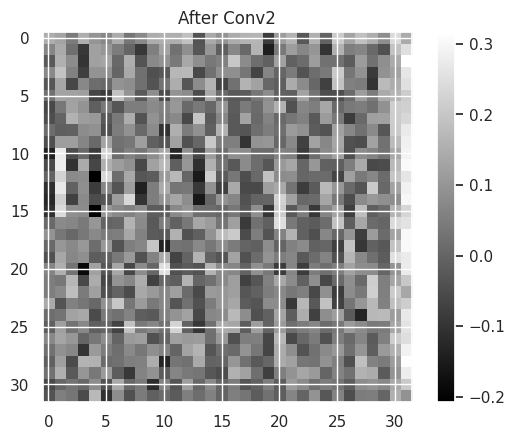

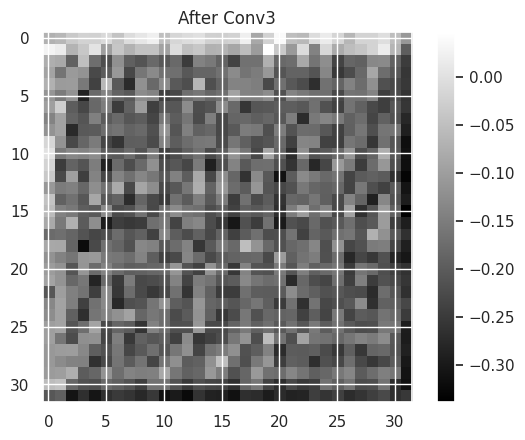

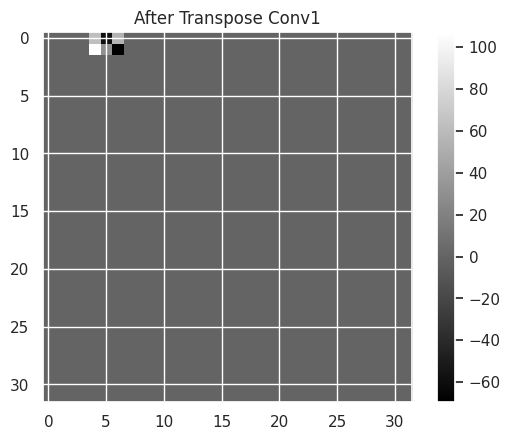

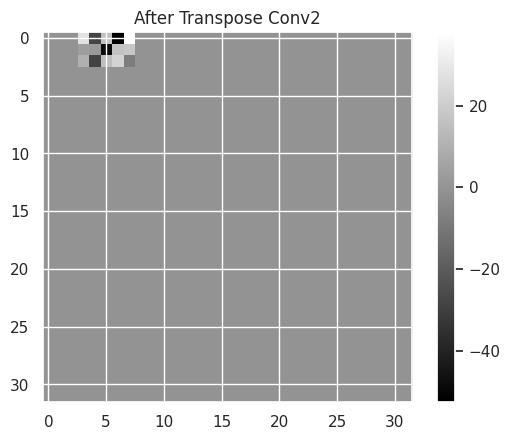

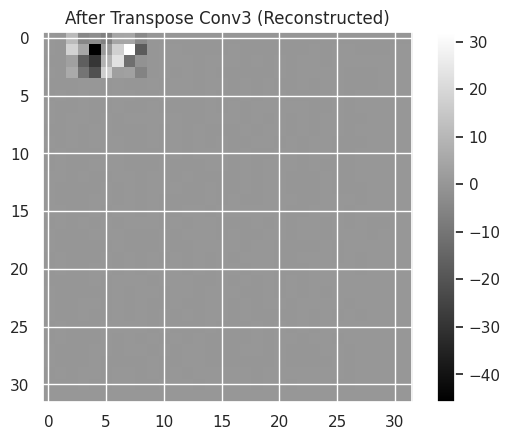

In [183]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Function to visualize a tensor
def visualize_tensor(tensor, title=''):
    tensor = tensor.detach()
    plt.imshow(tensor[0, 0, :, :].numpy(), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Generate a random tensor
input_tensor = torch.rand(1, 1, 32, 32)  # Batch size 1, 1 channel, 32x32 image
visualize_tensor(input_tensor, 'Input Tensor')

# Define convolution layers to demonstrate receptive field effect
conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)

# Apply convolutions
intermediate_tensor1 = conv1(input_tensor)
visualize_tensor(intermediate_tensor1, 'After Conv1')

intermediate_tensor2 = conv2(intermediate_tensor1)
visualize_tensor(intermediate_tensor2, 'After Conv2')

intermediate_tensor3 = conv3(intermediate_tensor2)
visualize_tensor(intermediate_tensor3, 'After Conv3')

# Simulate modification of some values in the final feature map
intermediate_tensor3_modified = intermediate_tensor3.clone()
intermediate_tensor3_modified[0, 0, 0, 5] = 1000.0  # Arbitrarily change a value

# Define transposed convolution layers to reconstruct the tensor
tconv1 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)
tconv2 = nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding=1)
tconv3 = nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=3, stride=1, padding=1)

# Apply transposed convolutions
reconstructed_tensor2 = tconv1(intermediate_tensor3_modified)
visualize_tensor(reconstructed_tensor2, 'After Transpose Conv1')

reconstructed_tensor1 = tconv2(reconstructed_tensor2)
visualize_tensor(reconstructed_tensor1, 'After Transpose Conv2')

reconstructed_tensor = tconv3(reconstructed_tensor1)
visualize_tensor(reconstructed_tensor, 'After Transpose Conv3 (Reconstructed)')